In [2]:
import os

os.chdir('..')

In [7]:
from src.utils import YamlReader
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt


In [4]:
data_path = 'data/10k_dataset.npy'

data = np.load(data_path, allow_pickle=True)


In [6]:
maze_example = data[0,0]
path_example = data[0,1]

In [12]:

def plot_maze(maze, name='maze'):
    # plot 1s as black squares
    # and 0s as white squares
    # use inverse cmap to make 0s white
    plt.imshow(maze, cmap='gray_r')
    plt.title('Maze (black squares are walls)')
    plt.show()

def plot_path(path, name='path'):
    # plot 1s as red squares
    # and 0s as white squares

    plt.imshow(path, cmap='gray_r')
    plt.title('(Optimal) path from entrance to exit (red squares)')
    # make tuples from neighboring 1's in the path
    CELL_PIXELS = 100//path.shape[0]
    LINEWIDTH = (CELL_PIXELS // 2) + 3

    # and plot them as a line
    for i in range(1, path.shape[0]-1):
        for j in range(1, path.shape[1]-1):
            if path[i, j] == 1:
                if path[i-1, j] == 1:
                    plt.plot([j, j], [i-1, i], 'r', linewidth=LINEWIDTH)
                if path[i+1, j] == 1:
                    plt.plot([j, j], [i, i+1], 'r', linewidth=LINEWIDTH)
                if path[i, j-1] == 1:
                    plt.plot([j-1, j], [i, i], 'r', linewidth=LINEWIDTH)
                if path[i, j+1] == 1:
                    plt.plot([j, j+1], [i, i], 'r', linewidth=LINEWIDTH)

    # for the entrance and exit points
    # also draw the line to the edge of the maze
    # to make it look more complete
    
    # find the entrance and exit points (1s on the edge of the maze)

    for i in range(path.shape[0]):
        if path[i, 0] == 1:
            entrance = (0, i)
            plt.plot([entrance[0]-0.5, entrance[0]], [entrance[1], entrance[1]], 'r', linewidth=LINEWIDTH)
        if path[i, -1] == 1:
            exit_ = (path.shape[1]-1, i)
            plt.plot([exit_[0], exit_[0]+0.5], [exit_[1], exit_[1]], 'r', linewidth=LINEWIDTH)

    for j in range(path.shape[1]):
        if path[0, j] == 1:
            entrance = (j, 0)
            plt.plot([entrance[0], entrance[0]], [entrance[1]-0.5, entrance[1]], 'r', linewidth=LINEWIDTH)
        if path[-1, j] == 1:
            exit_ = (j, path.shape[0]-1)
            plt.plot([exit_[0], exit_[0]], [exit_[1], exit_[1]+0.5], 'r', linewidth=LINEWIDTH)

    plt.show()


def plot_maze_and_path(maze, path):
    # plot 1s as black squares
    # and 0s as white squares
    # use inverse cmap to make 0s white
    plt.imshow(maze, cmap='gray_r')
    # make tuples from neighboring 1's in the path
    # and plot them as a line
    for i in range(1, path.shape[0]-1):
        for j in range(1, path.shape[1]-1):
            if path[i, j] == 1:
                if path[i-1, j] == 1:
                    plt.plot([j, j], [i-1, i], 'r')
                if path[i+1, j] == 1:
                    plt.plot([j, j], [i, i+1], 'r')
                if path[i, j-1] == 1:
                    plt.plot([j-1, j], [i, i], 'r')
                if path[i, j+1] == 1:
                    plt.plot([j, j+1], [i, i], 'r')

    # for the entrance and exit points
    # also draw the line to the edge of the maze
    # to make it look more complete
    
    # find the entrance and exit points (1s on the edge of the maze)

    for i in range(path.shape[0]):
        if path[i, 0] == 1:
            entrance = (0, i)
            plt.plot([entrance[0]-0.5, entrance[0]], [entrance[1], entrance[1]], 'r')
        if path[i, -1] == 1:
            exit_ = (path.shape[1]-1, i)
            plt.plot([exit_[0], exit_[0]+0.5], [exit_[1], exit_[1]], 'r')

    for j in range(path.shape[1]):
        if path[0, j] == 1:
            entrance = (j, 0)
            plt.plot([entrance[0], entrance[0]], [entrance[1]-0.5, entrance[1]], 'r')
        if path[-1, j] == 1:
            exit_ = (j, path.shape[0]-1)
            plt.plot([exit_[0], exit_[0]], [exit_[1], exit_[1]+0.5], 'r')
    
    # draw the entrance and exit lines
    plt.title('Maze with path (red line) from entrance to exit')
    plt.show()

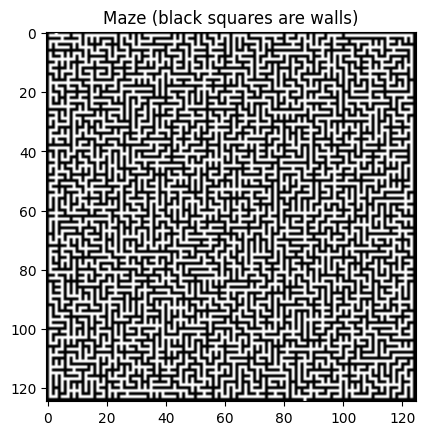

In [13]:
plot_maze(maze_example)

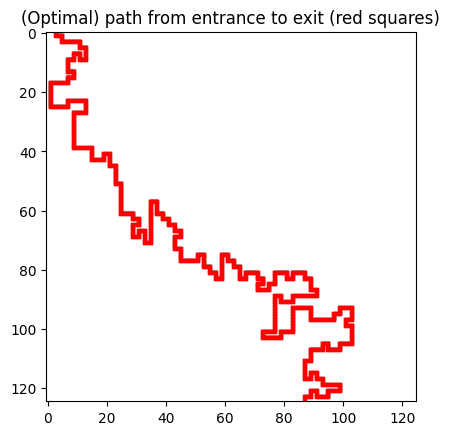

In [14]:
plot_path(path_example)

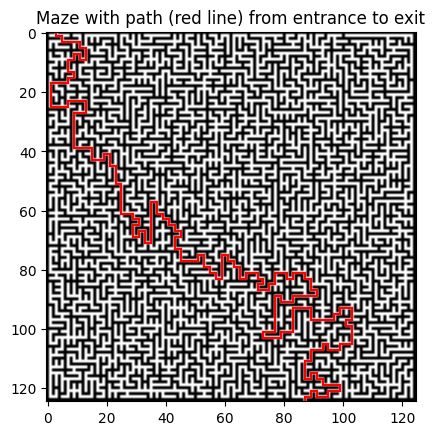

In [15]:
plot_maze_and_path(maze_example, path_example)

In [26]:
def compute_mean_node_degree(maze):
    # compute the mean node degree of the maze
    # by counting the number of neighbors of each node
    # and averaging over all nodes
    mean_node_degree = 0
    for i in range(1, maze.shape[0]-1):
        for j in range(1, maze.shape[1]-1):
            if maze[i, j] == 1:
                continue
            neighbors = 4 - maze[i-1, j] - maze[i+1, j] - maze[i, j-1] - maze[i, j+1]
            mean_node_degree += neighbors
    
    mean_node_degree /= (maze.shape[0]*maze.shape[1] - np.sum(maze))
    return mean_node_degree

mean_node_degree = compute_mean_node_degree(maze_example)

print(f'Mean node degree of the maze: {mean_node_degree}')

def count_node_degrees(maze):
    node_degrees_count = np.zeros(5)
    for i in range(1, maze.shape[0]-1):
        for j in range(1, maze.shape[1]-1):
            if maze[i, j] == 1:
                continue
            neighbors = 4 - maze[i-1, j] - maze[i+1, j] - maze[i, j-1] - maze[i, j+1]
            node_degrees_count[neighbors] += 1
    return node_degrees_count

def count_maze_degree_distribution(dataset):
    mazes = dataset[:, 0]
    node_degrees = np.zeros(5)
    for i, maze in enumerate(mazes):
        node_degrees += count_node_degrees(maze)
    return node_degrees


node_degrees = count_maze_degree_distribution(data)
print(f'Node degree distribution of the dataset: {node_degrees}')

def compute_maze_degree(dataset, return_all=False):
    mazes = dataset[:, 0]

    mean_node_degrees = np.zeros(mazes.shape[0])
    for i, maze in enumerate(mazes):
        mean_node_degrees[i] = compute_mean_node_degree(maze)
    
    if return_all:
        return mean_node_degrees, np.mean(mean_node_degrees), np.std(mean_node_degrees)
    
    return np.mean(mean_node_degrees), np.std(mean_node_degrees)

mean_node_degree, std_node_degree = compute_maze_degree(data)

print(f'Mean node degree of the dataset: {mean_node_degree}')
print(f'Std node degree of the dataset: {std_node_degree}')

def compute_path_length_stats(dataset, return_all=False):
    paths = dataset[:, 1]

    mean_path_length = np.zeros(paths.shape[0])

    for i, path in enumerate(paths):
        mean_path_length[i] = np.sum(path)
    
    if return_all:
        return mean_path_length, np.mean(mean_path_length), np.std(mean_path_length)
    return np.mean(mean_path_length), np.std(mean_path_length)

mean_path_length, std_path_length = compute_path_length_stats(data)

print(f'Mean path length of the dataset: {mean_path_length}')
print(f'Std path length of the dataset: {std_path_length}')

Mean node degree of the maze: 1.9994797763038106
Node degree distribution of the dataset: [      0. 1122756. 5575579.  854574.  134091.]
Mean node degree of the dataset: 1.9994797763038115
Std node degree of the dataset: 8.881784197001252e-16
Mean path length of the dataset: 438.396
Std path length of the dataset: 116.77144849662524


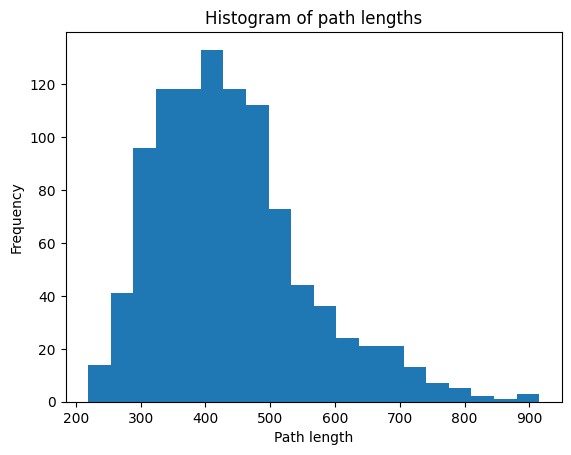

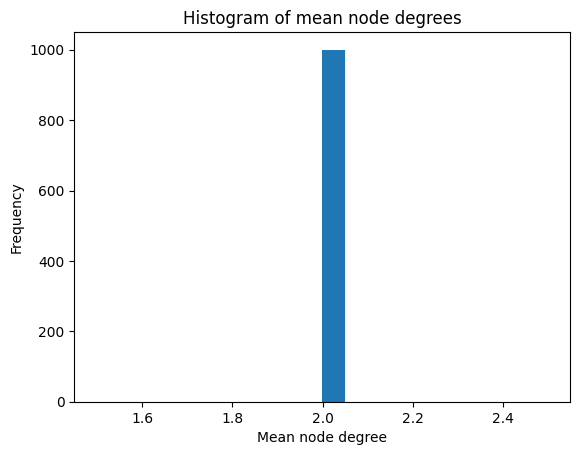

[0.         0.14605906 0.72532574 0.11117133 0.01744387]


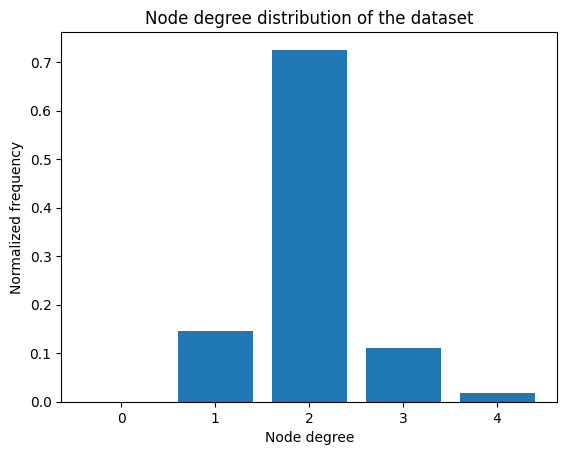

In [30]:
# Make a histogram of the path lengths

path_lengths, _, _ = compute_path_length_stats(data, return_all=True)

plt.hist(path_lengths, bins=20)
plt.title('Histogram of path lengths')
plt.xlabel('Path length')
plt.ylabel('Frequency')
plt.show()

mean_degrees, _, _ = compute_maze_degree(data, return_all=True)

plt.hist(mean_degrees, bins=20)
plt.title('Histogram of mean node degrees')
plt.xlabel('Mean node degree')
plt.ylabel('Frequency')
plt.show()

norm_node_degrees = node_degrees / np.sum(node_degrees)

print(norm_node_degrees)

node_degree_to_freq = {i: norm_node_degrees[i] for i in range(5)}
# plot as a bar chart

plt.bar(node_degree_to_freq.keys(), node_degree_to_freq.values())
plt.title('Node degree distribution of the dataset')
plt.xlabel('Node degree')
plt.ylabel('Normalized frequency')
plt.show()


In [35]:
def compute_ratio_straight_to_curl(data):
    mazes = data[:, 0]
    straight_paths = 0
    curl_paths = 0
    for maze in mazes:
        for i in range(1, maze.shape[0]-1):
            for j in range(1, maze.shape[1]-1):
                if maze[i, j] == 1:
                    continue
                straight_path = 0
                curl_path = 0

                if maze[i-1, j] == 0 and maze[i+1, j] == 0:
                    straight_path += 1
                if maze[i, j-1] == 0 and maze[i, j+1] == 0:
                    straight_path += 1
                if 4 - maze[i-1, j] - maze[i+1, j] - maze[i, j-1] - maze[i, j+1] == 1:
                    straight_path += 1
                
                if maze[i-1, j] == 0 and maze[i, j-1] == 0:
                    curl_path += 1
                if maze[i-1, j] == 0 and maze[i, j+1] == 0:
                    curl_path += 1
                if maze[i+1, j] == 0 and maze[i, j-1] == 0:
                    curl_path += 1
                if maze[i+1, j] == 0 and maze[i, j+1] == 0:
                    curl_path += 1

                straight_paths += straight_path
                curl_paths += curl_path
        
    return straight_paths, curl_paths

straight_paths, curl_paths = compute_ratio_straight_to_curl(data)

print(f'Number of straight paths: {straight_paths}')
print(f'Number of curl paths: {curl_paths}')
ratio_straight_curl = straight_paths / curl_paths
print(f'Ratio of straight to curl paths: {ratio_straight_curl}')

Number of straight paths: 6751861
Number of curl paths: 3314742
Ratio of straight to curl paths: 2.036919012098076
